In [437]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2
from helpers import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load the training data into feature matrix, class labels, and event ids:

In [438]:
from proj1_helpers import *
DATA_TRAIN_PATH = '' # TODO: download train data and supply path here 
y, tX, ids = load_csv_data("../data/train.csv")
print("done")

done


## Data Analyzing

In [439]:
# As we can see here, y only takes value -1 or 1:
for value in y:
    assert(value==1 or value==-1)
print("All value in y is equal either to 1 or -1.")


All value in y is equal either to 1 or -1.


This means that y is a binary variable. So should we modify y's coding to {0, 1} instead of {-1, 1} if we want the logistic regression methods to work?
Note that at first sight, logistic regression seems to be the best solution to fit the data since this method was designed for binary classification.

## Data Cleaning
We have to handle:
- outliers:
A value is considered as an outlier if it does not fit in a range defined from quartiles. Outliers are replaced by the mean value of the observations.
- unasssigned values (-999, 999):
We proceed the same way


In [440]:
print(tX.shape)
for col in tX.T:
    q1 = np.percentile(col,25)
    q3 = np.percentile(col,75)
    interq = q3-q1
    
    col_cleaned = col[abs(col)!=999]
    col_cleaned = col_cleaned[col_cleaned<=q3+interq]
    col_cleaned = col_cleaned[col_cleaned>=q1-interq]
    #print(col_cleaned.shape)
    mean = np.mean(col_cleaned)
    
    col[abs(col)==999] = mean
    col[col>q3+interq] = mean
    col[col<q1-interq] = mean
    
tX,_,_ = standardize(tX)
print("done")
print(tX.shape)

(250000, 30)
done
(250000, 31)


In [316]:
#print(tX[:, 1:tX.shape[1]].shape)
#tx2 = tX[:, 1:tX.shape[1]]
#print((tx2[:, 0]))
#print((tX[:, 0]))
#if(np.all(tX[:, 0] == 1.0)):
#print("check")

(250000, 30)
[  1.12800597e+00   2.01810042e+00  -1.84383694e-12 ...,  -1.79898422e-01
  -5.96123654e-01  -1.84383694e-12]
check


### Using PCA to get rid of features that don't give enough information

In [253]:
#C = 1/tX.shape[0]*tX.T.dot(tX)
#  
#eigenvalue, eigenvector = np.linalg.eig(C)
#SUM = np.sum(eigenvalue)
#
#idx = np.argsort(eigenvalue)[::-1]
#eigenvector = eigenvector[:,idx]
#eigenvalue = eigenvalue[idx]
#
#F = 0
#k = 0
#while F < 0.90:
#    F += eigenvalue[k]/SUM
#    k = k+1   
#
#eigenvector=eigenvector[:, :k]
#
#tX = np.dot(eigenvector.T, tX.T).T
#
#print(tX.shape)

## Some Helper Functions


In [484]:
# Some helper function:

def compute_gradient(y, tx, w):
    """Compute the gradient."""
    N = len(y)
    e = y - tx.dot(w)
    return (-1/N)*(tx.T).dot(e)

def compute_loss(y, tx, w):
    """Compute the cost by MSE"""
    N = len(y)
    e = y - tx.dot(w)
    return (1/(2*N))*((e.T).dot(e))

def build_poly(x, degree):
    """polynomial basis functions for input data x, for j=0 up to j=degree."""
    # concatenate column of ones of size (25000, 1)
    # if necessary get rid of the column of ones that's already there from standardization
    if(np.all(x[:, 0] == 1.0)):
        x = x[:, 1:x.shape[1]]
    result = np.ones((x.shape[0], 1))
    for i in range(1, degree+1):
       result = np.concatenate((result, x ** i), axis=1)
    return result

def split_data(x, y, ratio, seed=0):
    """Randomly splits the data given in input into two subsets (test/train).
    The ratio determines the size of the training set."""
    np.random.seed(seed)
    size = y.shape[0]
    # randomly permutes array of intergers from 0 to size-1
    indexes = np.random.permutation(size)
    tr_size = int(np.floor(ratio * size))
    # get (randomly generated) indexes of training/testing set
    tr_indexes = indexes[0:tr_size]
    te_indexes = indexes[tr_size:]
    # split x (resp. y) into two subarrays x_tr, x_te (resp. y_tr, y_te)
    x_tr = x[tr_indexes]
    y_tr = y[tr_indexes]
    x_te = x[te_indexes]
    y_te = y[te_indexes]
    return [x_tr, y_tr, x_te, y_te]

def sigmoid_scal(t):
    """apply sigmoid function on t."""
    if(t < 0):
        return np.exp(t)/(1+np.exp(t))
    else:
        return 1/(1+np.exp(-t))
    
sigmoid = np.vectorize(sigmoid_scal)
    

def calculate_loss(y, tx, w):
    """compute the cost by negative log likelihood."""
    loss = 0
    for index, row in enumerate(tx):
        loss += np.log(1+np.exp(row.dot(w)))-y[index]*(row).dot(w)
    return loss

def calculate_gradient(y, tx, w):
    """compute the gradient of loss."""
    return tx.T.dot(sigmoid(tx.dot(w))-y)

def learning_by_gradient_descent(y, tx, w, gamma):
    """
    Do one step of gradient descent using logistic regression.
    Return the loss and the updated w.
    """   
    grad = calculate_gradient(y,tx,w)
    loss = calculate_loss(y, tx, w)
    w -= gamma*grad
    return w, loss

def error(y,y_est):
    """Computes the percentage of right values in the 
    regression result compared to our test data"""
    diff = np.count_nonzero(y-y_est)/len(y)
    return (1-diff)*100

def minus_one_to_zero(y):
    """The domain of the y vector changes from {-1,1} to {0,1}.
    This is useful for logistic regression."""
    assert(np.any(y==-1))
    return (y+1)/2

def zero_to_minus_one(y):
    """The domain of the y vector changes from {0,1} to {-1,1}.
    This is useful for logistic regression."""
    assert(np.any(y==0))
    return 2*y-1
    

## Split the data into two parts

In [468]:
tX, y, tX_te, y_te = split_data(tX, y, 2/3)

In [469]:
print(tX.shape)

(166666, 31)


## Functions to implement

In [477]:
def least_squares_GD(y, tx, initial_w, max_iters, gamma):
    """performs linear regression using gradient descent algorithm. 
    Returns two arrays containing weights and loss values 
    at each step of the algorithm."""
    # Define parameters to store w and loss
    ws = [initial_w]
    losses = []
    w = initial_w
    for n_iter in range(max_iters):
        # compute gradient and loss
        gradient = compute_gradient(y, tx, w)
        loss = compute_loss(y, tx, w)
        #update w
        w = w - gamma * gradient
        # store w and loss
        ws.append(np.copy(w))
        losses.append(loss)
    return w, loss


def least_squares_SGD(y, tx, initial_w, max_iters, gamma):
    """performs linear regression using stochastic gradient descent algorithm. 
    Returns two arrays containing weights and loss values 
    at each step of the algorithm."""
    ws = [initial_w]
    losses = []
    w = initial_w
    batch_size = 800 #try changing batch size
    
    for n_iter in range(max_iters):
        print("iteration", n_iter)
        for minibatch_y, minibatch_tx in batch_iter(y, tx, batch_size):
            gradient = compute_gradient(minibatch_y, minibatch_tx, w)
            #compute new loss and w
            loss = compute_loss(y, tx, w) # add one loss per minibatch (compute mean)
            w = w - gamma * gradient
            # store loss and w in arrays
            ws.append(w)
            losses.append(loss)
                 
    return w, loss

def least_squares(y, tx):
    """performs linear regression by calculating 
    the least squares solution using normal equations.
    returns loss and optimal wieghts."""
    opt_w = np.linalg.inv(tx.T.dot(tx)).dot(tx.T).dot(y)
    #computes the loss using MSE
    mse = compute_loss(y, tx, opt_w)
    return opt_w, mse
    
def ridge_regression(y, tx, lambda_):
    """implement ridge regression. This calculates the MSE while taking in 
    accout a regularizer that is determined by lambda. This has for effect to
    penalize/avoid large weights in order to avoid overfitting."""
    # tx is the polynomial basis
    opt_w = (np.linalg.inv(tx.T.dot(tx)+lambda_*2*len(y)*np.identity(tx.shape[1])).dot(tx.T)).dot(y)
    mse = compute_loss(y, tx, opt_w)
    return opt_w, mse

def logistic_regression(y, tx, max_iter, gamma):
    threshold = 1e-350
    losses = np.array([0,1])
    w = np.zeros(tx.shape[1])
    
    # start the logistic regression
    for iter in range(max_iter):
        # get loss and update w.
        w, loss = learning_by_gradient_descent(y, tx, w, gamma)
        losses[1] = losses[0]
        losses[0] = loss
        if iter % 50 == 0:
            print("Current iteration={i}, the loss={l}".format(i=iter, l=loss))
        # Condition d'arrêt: 
        if abs(losses[0]-losses[1]) < abs(losses[1]*threshold):
            break
            
    print("The loss={l}".format(l=calculate_loss(y, tx, w)))
    return w, loss

    
def reg_logistic_regression(y, tx, lambda_, initial_w, max_iters, gamma):
    #TODO
    raise NotImplementedError


In [471]:
### logistic regression test
max_iter = 300
gamma = 10e-5
y01 = minus_one_to_zero(y)

y_red = y01[0:10000]
x_red = tX[0:10000]

w,loss = logistic_regression(y_red, x_red, max_iter, gamma)
print(error(y_te,predict_labels(w,tX_te)))

Current iteration=0, the loss=6931.471805600547
Current iteration=10, the loss=4863.227221282203
Current iteration=20, the loss=4808.499350856127
Current iteration=30, the loss=4798.698514533813
Current iteration=40, the loss=4795.933520174678
Current iteration=50, the loss=4794.950444113021
Current iteration=60, the loss=4794.544244830425
Current iteration=70, the loss=4794.354253765837
Current iteration=80, the loss=4794.255090032426
Current iteration=90, the loss=4794.1984039744875
Current iteration=100, the loss=4794.163723068511
Current iteration=110, the loss=4794.141503430428
Current iteration=120, the loss=4794.126844105239
Current iteration=130, the loss=4794.116997951601
Current iteration=140, the loss=4794.1103133212855
Current iteration=150, the loss=4794.10574599067
Current iteration=160, the loss=4794.10261339662
Current iteration=170, the loss=4794.100459907386
Current iteration=180, the loss=4794.09897743118
Current iteration=190, the loss=4794.097956006669
Current iter

## Use Polynomial Regression to find the optimal degree

RMSE for degree 1 : 0.795089290362
RMSE for degree 2 : 0.772429591799
RMSE for degree 3 : 0.749385237938
RMSE for degree 4 : 0.887131255846
RMSE for degree 5 : 8.04364351084
RMSE for degree 6 : 1.48727512735
RMSE for degree 7 : 1.47115258664
RMSE for degree 8 : 1.1105923246
RMSE for degree 9 : 5.77422577771
RMSE for degree 10 : 46.7964419249
The best degree among those we tested is 3 .


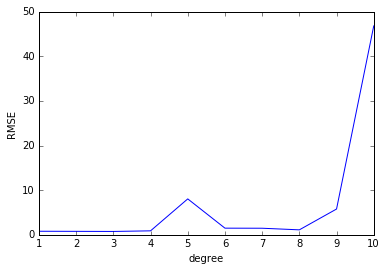

In [402]:
def polynomial_regression():
    """For each degree, constructs the polynomial basis function expansion of the data
       and stores the corresponding RMSE in an array. At the end we chose the degree that
       generated the smallest RMSE. Of course we cannot test all degrees so this is not
       optimal but it helps us having a good idea of the optimal degree value."""
    # define parameters
    degrees = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    
    # for each degree we store the corresponding RMSE in this array
    rmse_array = np.array([])

    for ind, degree in enumerate(degrees):
        # form the data to do polynomial regression:
        polynomial_basis = build_poly(tX, degree)
        
        # least square and calculate rmse:
        weight, mse = least_squares(y, polynomial_basis)
        rmse = np.sqrt(2*mse)
        rmse_array = np.append(rmse_array, rmse)
        print("RMSE for degree", degree, ":", rmse)
    
    # plot the RMSE in function of the degree
    plt.plot(degrees, rmse_array)
    plt.xlabel('degree')
    plt.ylabel('RMSE')
    
    #compute the best degree
    best_degree = degrees[np.argmin(rmse_array)]
    print("The best degree among those we tested is", best_degree, ".")

polynomial_regression()

### Results
Looking at the results, it seems like 3 is the optimal degree. However, we might be overfitting the data because there is no regularization step in polynomial_regression. Also the result is biased because the data is not split into training/testing subsets. Thus we'll use the Ridge regression, which uses a regularizer that depends on a parameter lambda.
We'll compute the RMSE for different lambda and degree values in order to determine the best ones.

## Use Ridge Regression to determine optimal lambda
This is a demo where we use ridge regression to deduce the loss function and the error percentage of the testing data for each (degree, lambda) pair. We iterate over different degree/lambda values to find the best ones. Recall that lambda is a coefficient penalizing the size of regression coefficients. Ridge regression introduces bias but reduces the variance of the estimate.

Best training RMSE is 0.744307856954 with degree 10 and lambda= 0.000268269579528 

Best fitting is 81.2213122131 % with degree 10 and lambda= 0.000117876863479 



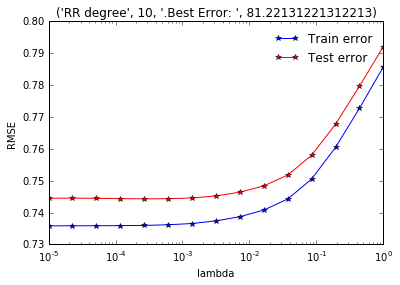

In [388]:
def ridge_regression_demo(x, y, ratio, seed):
    """Calculate polyomial basis tX from x with given degree,
    splits the data according to given ratio and then run
    ridge regression on tX, y with different lambda values.
    At the end we plot the RMSEs of training/testing set in
    function of lambda in order to determine the best lambda value"""
    # define parameter
    lambdas = np.logspace(-5, 0, 15)
    degrees = [10]
    
    # split the data, and return train and test data:
    x_tr, y_tr, x_te, y_te = split_data(x, y, ratio, seed)
    
    #calculate test/train RMSE for each lambda and store them in lists
    rmse_list_tr = np.empty([len(degrees), len(lambdas)])
    rmse_list_te = np.empty([len(degrees), len(lambdas)])
    errors = np.empty([len(degrees), len(lambdas)])
    optimal_weights_err = np.empty([np.shape(tX)[1]])
    optimal_weights_rmse_te = np.empty([np.shape(tX)[1]])
    best_err = 0
    best_RMSE = 10e10
    for i, degree in enumerate(degrees):
        # for each lambda, store the best RMSE and the degree that generated it
        for j, lambd in enumerate(lambdas):
            # compute polynomial basis from given degree
            poly_basis_tr = build_poly(x_tr, degree)
            poly_basis_te = build_poly(x_te, degree)
            # compute training and testing (R)MSE for current lambda/degree
            w_tr, mse_tr = ridge_regression(y_tr, poly_basis_tr,lambd)
            mse_te = compute_loss(y_te, poly_basis_te, w_tr)
            rmse_tr = np.sqrt(2*mse_tr)
            rmse_te = np.sqrt(2*mse_te)
            err = error(y_te,predict_labels(w_tr,poly_basis_te))
            #print("Training RMSE for lambda =", lambd, "and degree", degree, ":", rmse_tr, "\n")
            #print("Testing RMSE for lambda =", lambd, "and degree", degree, ":", rmse_te, "\n")
            #print("error for lambda = ", lambd, "and degree", degree, ":", err)
            # Store RMSEs in arrays
            rmse_list_tr[i][j] = rmse_tr
            rmse_list_te[i][j] = rmse_te
            errors[i][j] = err
            # we do this to get optimal weights according to the error
            if(best_err < err):
                best_err = err
                optimal_weights_err = w_tr
            # get the optimal weights according to the testing rmse
            if(best_RMSE > rmse_te):
                best_RMSE = rmse_te
                optimal_weights_rmse_te = w_tr
        # plot figures
        plt.figure(i)
        plot_train_test(rmse_list_tr[i, :], rmse_list_te[i, :], lambdas, degree)
        # TODO we need to compute the error for each (d, lambda) value, store all in array and print best for each degree
        err = error(y_te,predict_labels(w_tr,poly_basis_te))
        plt.title(("RR degree", degree, ".Best Error: ", best_err))
    
    # get best degree, lambda according to the testing RMSE
    degree_index_te, lambd_index_te = np.where(rmse_list_te == rmse_list_te.min())
    degree_index_te, lambd_index_te = (degree_index_te[0],lambd_index_te[0])
    best_rmse_te = rmse_list_te[degree_index_te][lambd_index_te]
    print("Best training RMSE is", best_rmse_te, "with degree", degrees[degree_index_te], "and lambda=", lambdas[lambd_index_te], "\n")
    # get best degree and lambda according to the error
    degree_index_err, lambd_index_err = np.where(errors == errors.max())
    degree_index_err, lambd_index_err = (degree_index_err[0],lambd_index_err[0])
    best_error = errors[degree_index_err][lambd_index_err]
    print("Best fitting is", best_error, "% with degree", degrees[degree_index_err], "and lambda=", lambdas[lambd_index_err], "\n")
    #return optimal_weights, best_RMSE
    return optimal_weights_rmse_te, best_rmse_te
    
seed = 1
split_ratio = 0.8
w, loss = ridge_regression_demo(tX, y, split_ratio, seed)

After running a few tests with ridge regression, it seems like we should not go above degree 10.

## Computing the weights with different methods

In [332]:
#initial values
gamma = 1e-7
initial_w = 0*np.ones(len(tX[0])) #try changing initial w
max_iters = 10
poly_basis = build_poly(tX, 2)

### Least Squares

In [333]:
w, loss = least_squares(y, tX)
print(error(y_te,predict_labels(w,tX_te)))

77.11498308013536


### Least Squares with polynomial basis

In [338]:
w, loss = least_squares(y, poly_basis)
# build a polynomial basis of the same size as training set for the testing set
tX_te_poly = build_poly(tX_te, 2)
print(error(y_te,predict_labels(w,tX_te_poly)))

79.28036575707395


### Least Squares - Gradient Descent

In [203]:
w, loss = least_squares_GD(y, tX, initial_w, max_iters, gamma)
print(error(y_te,predict_labels(w,tX_te)))

34.42052463580291


### Least Squares - Stochastic Gradient Descent

In [204]:
w, loss = least_squares_SGD(y, tX, initial_w, max_iters, gamma)
print(error(y_te,predict_labels(w,tX_te)))

iteration 0
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
34.440924472604216


### Ridge Regression

In [436]:
# to find optimal degree and lambda, check "Use RR to determine optimal
# lambda and degree" section
degree = 10
poly_basis = build_poly(tX, degree)
lambda_ = 1e-04
tX_te_poly = build_poly(tX_te, 10)
w, loss = ridge_regression(y, poly_basis, lambda_)
print(error(y_te,predict_labels(w,tX_te_poly)))

81.53694770441837


In [430]:
print(min(y))

-1.0


### Ridge regression with data splitting and chosing best lambda/deg

In [399]:
# TODO, we should remove this section, this code is already ran above under function definition and is only here
# for explanation/demonstration purpose
seed = 1
split_ratio = 0.8
#w, loss = ridge_regression_demo(tX, y, split_ratio, seed)
#print(error(y_te,predict_labels(w,tX_te)))

In [341]:
print(tX_test.shape)

(568238, 32)


### Logistic Regression

In [474]:
max_iter = 100
gamma = 10e-5
y01 = minus_one_to_zero(y)

y_red = y01[0:10000]
x_red = tX[0:10000]

w,loss = logistic_regression(y_red, x_red, max_iter, gamma)
print(error(y_te,predict_labels(w,tX_te)))

Current iteration=0, the loss=6931.471805600547
Current iteration=10, the loss=4863.227221282203
Current iteration=20, the loss=4808.499350856127
Current iteration=30, the loss=4798.698514533813
Current iteration=40, the loss=4795.933520174678
Current iteration=50, the loss=4794.950444113021
Current iteration=60, the loss=4794.544244830425
Current iteration=70, the loss=4794.354253765837
Current iteration=80, the loss=4794.255090032426
Current iteration=90, the loss=4794.1984039744875
The loss=4794.163723068511
77.36218110255118


### Logistic Regressio with polynomial basis

In [485]:
max_iter = 150
gamma = 10e-5
y01 = minus_one_to_zero(y)

y_red = y01[0:1000]
x_red = tX[0:1000]
degrees = [1, 2, 3, 4, 5]
for degree in degrees:
    x_red_poly_basis = build_poly(x_red, degree)
    w,loss = logistic_regression(y_red, x_red_poly_basis, max_iter, gamma)
    tX_te_poly = build_poly(tX_te, degree)
    print("fitting % for degree",degree,":",error(y_te,predict_labels(w,tX_te_poly)))

Current iteration=0, the loss=693.1471805599322
Current iteration=50, the loss=476.91560916082864
Current iteration=100, the loss=457.3971525405103
The loss=451.0880234527123
fitting % for degree 1 : 76.32058943528452
Current iteration=0, the loss=693.1471805599322
Current iteration=50, the loss=428.39151253226265
Current iteration=100, the loss=410.96562142800707
The loss=404.4942353342304
fitting % for degree 2 : 78.46017231862146
Current iteration=0, the loss=693.1471805599322
Current iteration=50, the loss=512.001995595834
Current iteration=100, the loss=558.3316230096852
The loss=410.1678836092355
fitting % for degree 3 : 77.40538075695395
Current iteration=0, the loss=693.1471805599322


C:\Users\rbsteinm\Anaconda3\lib\site-packages\ipykernel\__main__.py:58: RuntimeWarning: overflow encountered in exp


OverflowError: cannot convert float infinity to integer

## Generate predictions and save ouput in csv format for submission:

In [442]:
DATA_TEST_PATH = '../data/test.csv' # TODO: download train data and supply path here 
_, tX_test, ids_test = load_csv_data(DATA_TEST_PATH)
print("done")

done


In [443]:
# test ridge regression with poly basis of degree 10
lambda_ = 1e-04
degree = 10
tX_test,_,_ = standardize(tX_test)
poly_basis_te = build_poly(tX_test, degree)
poly_basis_tr = build_poly(tX, degree)
w, loss = ridge_regression(y, poly_basis_tr, lambda_)
print("done")

done


In [446]:
print(w.shape)
print(tX_test.shape)

(301,)
(568238, 31)


In [447]:
OUTPUT_PATH = '../data/submissionData/ridgeRegressionPolyBasis_degree10.csv' # TODO: fill in desired name of output file for submission

o = np.ones((tX_test.shape[0],1))

y_pred = predict_labels(w, poly_basis_te)
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)
print("done")

done


In [448]:
print(y_pred.shape)

(568238,)
